In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-07-20T14:03:06.552230+03:00

Python implementation: CPython
Python version       : 3.7.10
IPython version      : 7.22.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 158 Stepping 9, GenuineIntel
CPU cores   : 8
Architecture: 64bit



In [3]:
import os
import pickle as pkl

import numpy as np
import pandas as pd

from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn import preprocessing

from typing import Tuple

In [4]:
from xgboost import __version__ as xgb_version
from sklearn import __version__ as sklearn_version

print(f'xgb_version: {xgb_version}')
print(f'sklearn_version: {sklearn_version}')

xgb_version: 1.6.1
sklearn_version: 0.24.2


In [5]:
%watermark --iversions

numpy  : 1.20.3
pandas : 0.25.3
sklearn: 0.24.2
xgboost: 1.6.1



## Reproducibility block

In [6]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

CB_RANDOMSEED = 309487
XGB_RANDOMSEED = 56

In [7]:
DIR_DATA   = os.path.join(os.getcwd(), 'data')
DIR_MODELS = os.path.join(os.getcwd(), 'models')
DIR_SUBM   = os.path.join(os.getcwd(), 'subm')
DIR_SUBM_PART = os.path.join(os.getcwd(), 'subm', 'partial')

In [8]:
NTRY = 24
NAME = f'{NTRY}_xgb_pca64_sber_bord_nose_iter_poly'

In [9]:
VIEWS_UKR = 2554204
DEPTH_UKR = 1.799
FPR_UKR = 4.978

## Load data

In [10]:
df_train  = pd.read_csv(os.path.join(DIR_DATA, 'train_upd.csv'))#, index_col= 0)
df_test  = pd.read_csv(os.path.join(DIR_DATA, 'test_upd.csv'))#, index_col= 0)
    
with open(os.path.join(DIR_DATA, 'clmns.pkl'), 'rb') as pickle_file:
    clmns = pkl.load(pickle_file)


In [11]:
df_train.shape, df_test.shape, 

((6981, 338), (3000, 335))

In [12]:
cat_cols = []
num_cols = []

for el in clmns.keys():
    cat_cols.extend(clmns[el]['cat'])
    num_cols.extend(clmns[el]['num'])
    if len(clmns[el]['both']) != 0:
        print(clmns[el]['both'])

['ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr']
['hour', 'dow', 'day', 'mounth', 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr']


In [13]:
num_cols.extend(['hour', 'mounth', 'dow',
                'ph_report', 'ph_gallery', 'tv_prog', 'online', 'video', 'infogr',
                 'holiday', 'day_before_holiday', 'day_after_holiday', 'distrib_brdr',
                 'two_articles',
                 #'spec_event_1',
                ])
#cat_cols.extend(['dow'])

In [14]:
def plot_importance(inp_model, imp_number = 30, imp_type = 'weight'):
    feature_important = inp_model.get_booster().get_score(importance_type=imp_type)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(imp_number, columns="score").plot(kind='barh', figsize = (30,16)) ## plot top 40 features

In [15]:
#def r2(predt: np.ndarray, dtrain: xgb.DMatrix) -> Tuple[str, float]:
def r2(y_pred: np.ndarray, y_true: xgb.DMatrix) -> Tuple[str, float]:
    
    return 'r2', r2_score(y_true.get_label(), y_pred)

## views

In [16]:
#xgb.set_config(verbosity=0)
#xgb_spec = ['day', 'mounth', 'authors_int', 'category_int']

In [17]:
cv_ntrees = 500

xgb_params_views = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
    #'num_boost_round': 10000, 
    #'early_stopping_rounds': 100,
}
dtrain_v = xgb.DMatrix(df_train[num_cols], label=df_train[['views']])
#dtrain = xgb.DMatrix(df_train[xgb_spec], label=df_train[['views']])

In [18]:
%%time
scores_v = xgb.cv(xgb_params_views, dtrain_v, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
#scores_v.tail(5)

Wall time: 2min 8s


In [19]:
#if scores_v['test-rmse-mean'].argmin() != scores_v['test-r2-mean'].argmax():
#    raise ValueError('wtf?', scores_v['test-rmse-mean'].argmin(), scores_v['test-r2-mean'].argmax())

In [45]:
scores_v[scores_v['test-rmse-mean'] == scores_v['test-rmse-mean'].min()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
4,28364.803892,2443.120953,44615.079651,13079.682544,0.7792,0.007696,0.418402,0.133857


In [21]:
views_iter = scores_v['test-rmse-mean'].argmin()

In [22]:
xgb_model_views = XGBRegressor(n_estimators=views_iter, 
                               #max_depth=7, 
                               #eta=0.1, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_views.fit(df_train[num_cols], df_train['views'], 
                    verbose=False
                   )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=4, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, reg_lambda=1, ...)

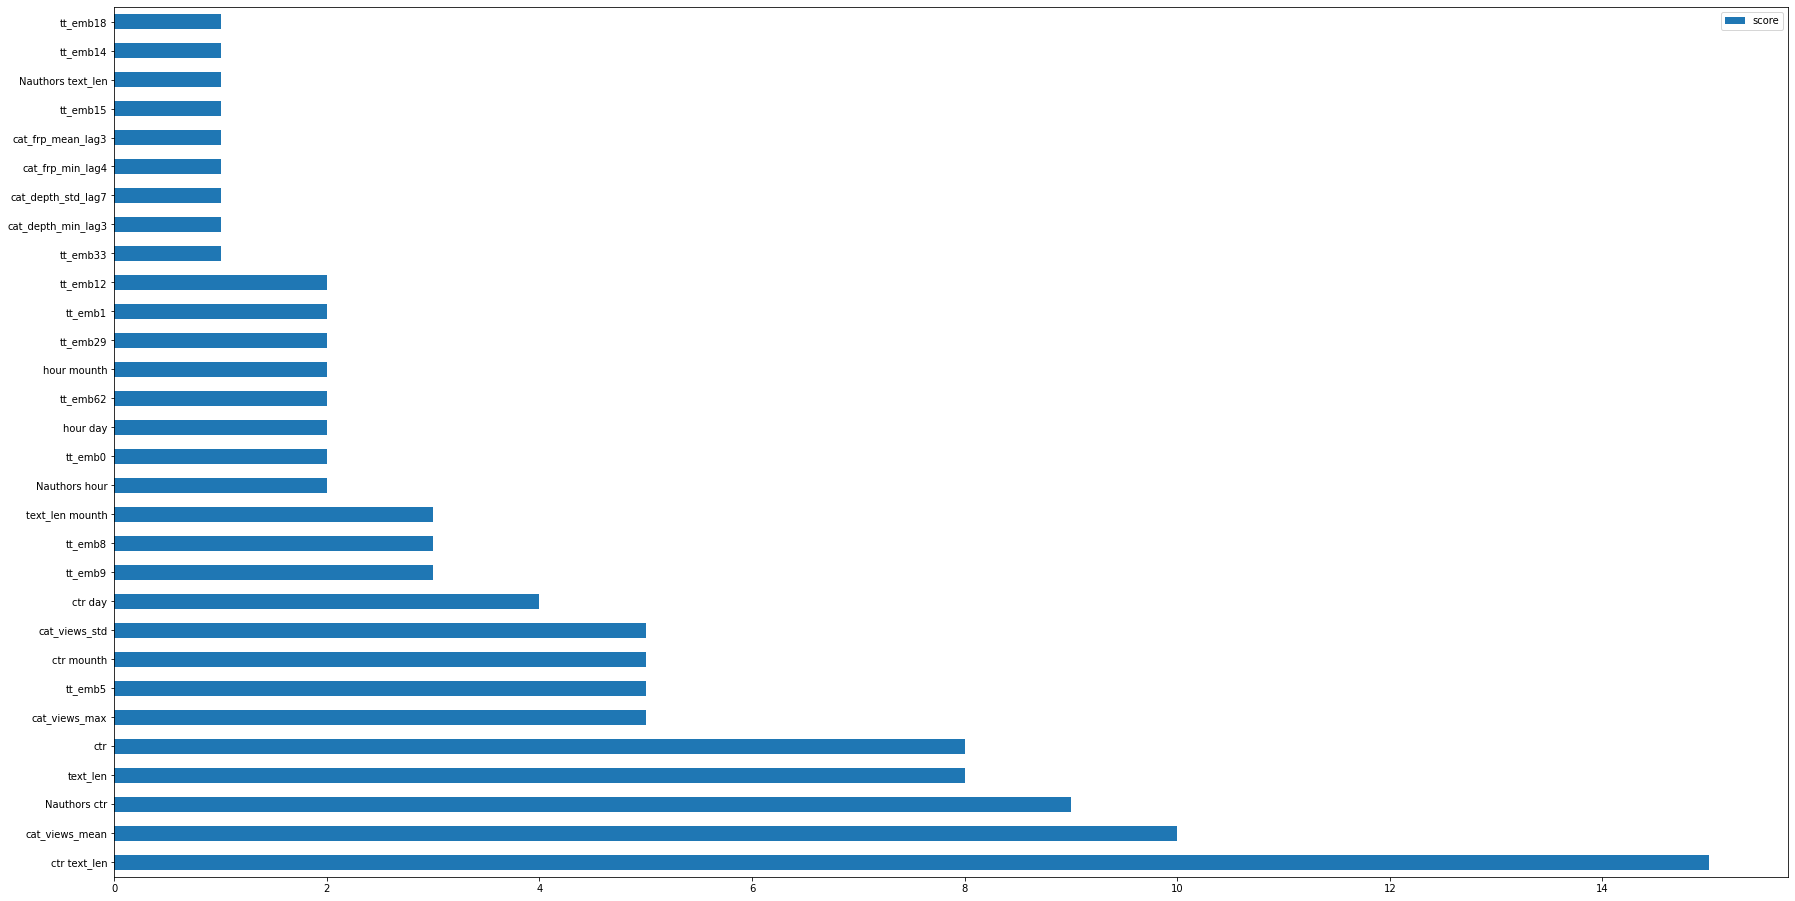

In [23]:
plot_importance(xgb_model_views, 30, 'weight')

## depth

In [24]:
xgb_params_depth = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'n_estimators': 1000, 
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
 #   'num_boost_round': 10000, 
 #   'early_stopping_rounds': 100,
}
dtrain_d = xgb.DMatrix(df_train[num_cols], label=df_train[['depth']])

In [25]:
%%time
scores_d = xgb.cv(xgb_params_depth, dtrain_d, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
#scores_d.tail()

Wall time: 1min 29s


In [26]:
#if scores_d['test-rmse-mean'].argmin() != scores_d['test-r2-mean'].argmax():
#    raise ValueError('wtf?', scores_d['test-rmse-mean'].argmin(), scores_d['test-r2-mean'].argmax())

In [27]:
scores_d[scores_d['test-rmse-mean'] == scores_d['test-rmse-mean'].min()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
26,0.014362,0.000431,0.026243,0.000986,0.945965,0.002545,0.818893,0.012305


In [28]:
depth_iter = scores_d['test-rmse-mean'].argmin()

In [29]:
xgb_model_depth = XGBRegressor(n_estimators=depth_iter, 
                               #max_depth=7, 
                               #eta=0.1, 
                               #subsample=0.7, 
                               #colsample_bytree=0.8,
                               n_jobs = -1,
                               random_state = XGB_RANDOMSEED,
                              )

xgb_model_depth.fit(df_train[num_cols], df_train['depth'], 
                    verbose=False
                   )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=26, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, reg_lambda=1, ...)

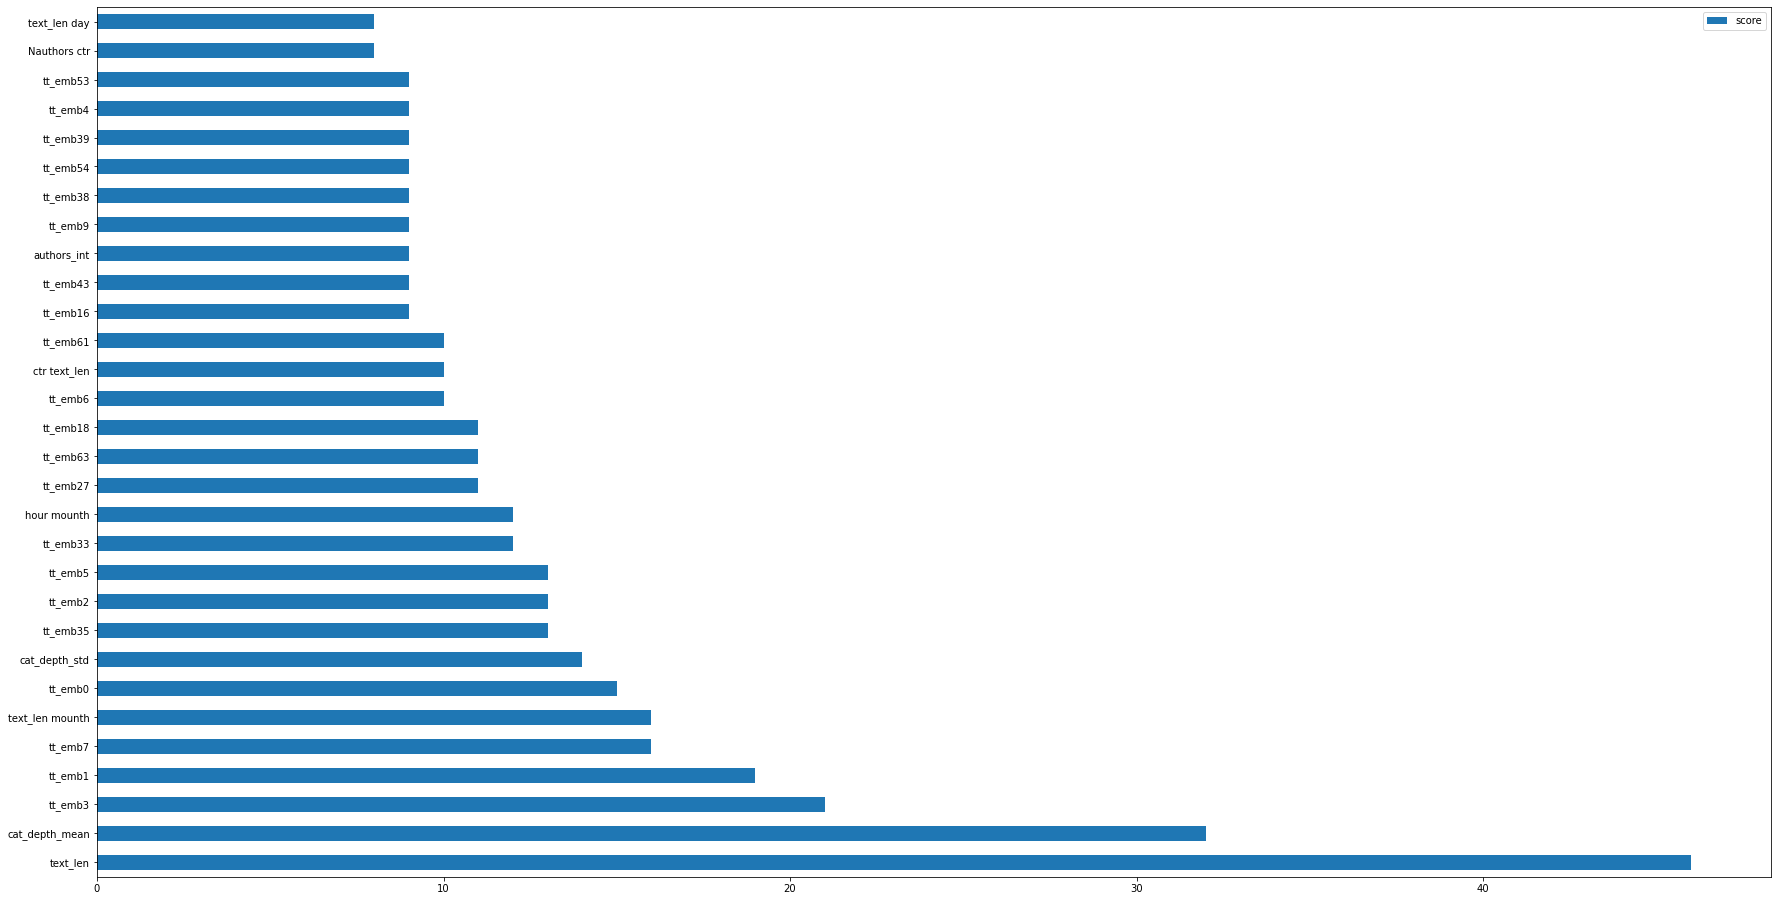

In [30]:
plot_importance(xgb_model_depth, 30, 'weight')

## full_reads_percent

In [31]:
xgb_params_fpr = {
    'booster': 'gbtree',
    'objective': 'reg:squarederror',
    #'n_estimators': 1000, 
    #'learning_rate': 0.05,
    #'eta': 0.3,
    #'max_depth': 15, 
 #   'num_boost_round': 10000, 
 #   'early_stopping_rounds': 100,
}
dtrain_f = xgb.DMatrix(df_train[num_cols], label=df_train[['full_reads_percent']])

In [32]:
%%time
scores_f = xgb.cv(xgb_params_fpr, dtrain_f, cv_ntrees, nfold=5, #early_stopping_rounds=1000,
        metrics={'rmse'},
        custom_metric = r2,
       #callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]
      )
#scores_f.tail()

Wall time: 2min 11s


In [33]:
#if scores_f['test-rmse-mean'].argmin() != scores_f['test-r2-mean'].argmax():
#    raise ValueError('wtf?', scores_f['test-rmse-mean'].argmin(), scores_f['test-r2-mean'].argmax())

In [34]:
scores_f[scores_f['test-rmse-mean'] == scores_f['test-rmse-mean'].min()][:1]

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std,train-r2-mean,train-r2-std,test-r2-mean,test-r2-std
14,4.764348,0.027847,6.882004,0.069276,0.779366,0.002174,0.53897,0.015132


In [35]:
frp_iter = scores_f['test-rmse-mean'].argmin()

In [36]:
xgb_model_frp = XGBRegressor(n_estimators=frp_iter,
                             #max_depth=7, 
                             #eta=0.1, 
                             #subsample=0.7, 
                             #colsample_bytree=0.8,
                             n_jobs = -1,
                             random_state = XGB_RANDOMSEED,
                             )

xgb_model_frp.fit(df_train[num_cols], df_train['full_reads_percent'],
                  verbose=False
                 )

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=14, n_jobs=-1,
             num_parallel_tree=1, predictor='auto', random_state=56,
             reg_alpha=0, reg_lambda=1, ...)

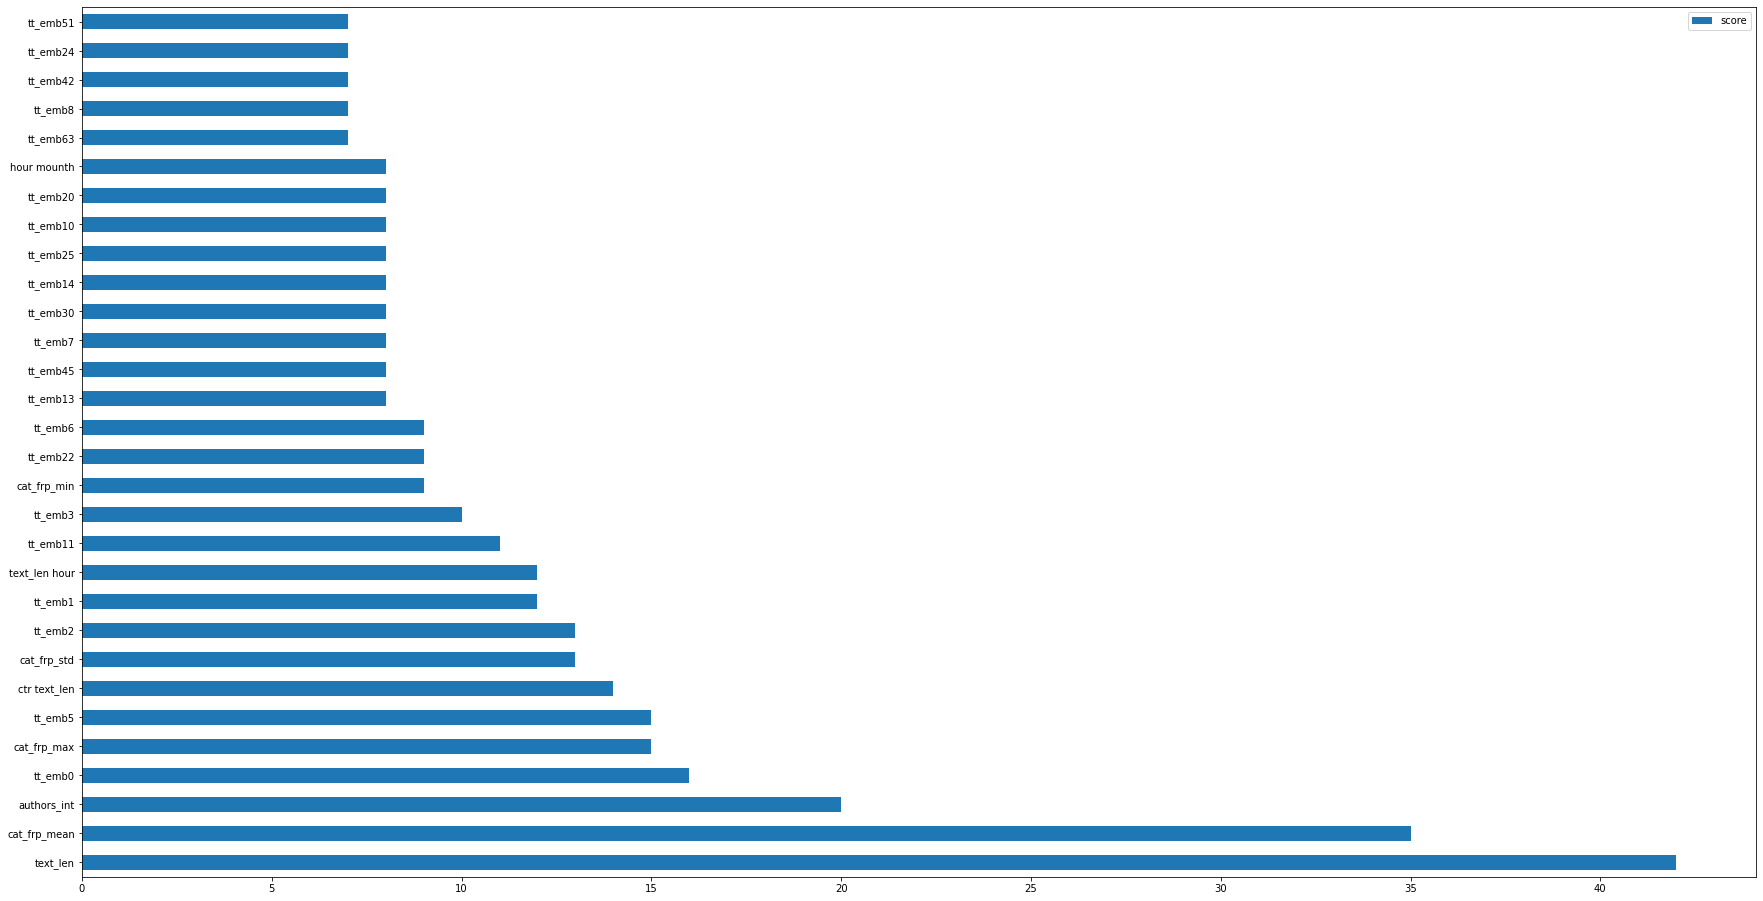

In [37]:
plot_importance(xgb_model_frp, 30, 'weight')

# Сохраняем предсказания для ансамблей / стекинга

## save models

In [38]:
xgb_model_views.save_model(os.path.join(DIR_MODELS, f'{NAME}_v.json'), 
                          )

xgb_model_depth.save_model(os.path.join(DIR_MODELS, f'{NAME}_d.json'), 
                          )

xgb_model_frp.save_model(os.path.join(DIR_MODELS, f'{NAME}_f.json'), 
                        )

C:\Users\_v010ch_\Anaconda3\lib\site-packages\xgboost\sklearn.py:722: UserWarning: n_estimators is not saved in Scikit-Learn meta.
  warnings.warn(str(k) + ' is not saved in Scikit-Learn meta.', UserWarning)


## make predict

In [39]:
pred_views = xgb_model_views.predict(df_test[num_cols])
pred_depth = xgb_model_depth.predict(df_test[num_cols])
pred_frp   = xgb_model_frp.predict(  df_test[num_cols])

In [40]:
subm = pd.DataFrame()
subm['document_id'] = df_test.document_id

subm['views'] = pred_views
subm['depth'] = pred_depth
subm['full_reads_percent'] = pred_frp

In [41]:
doc_id_ukr = df_test[df_test.spec == 1].document_id.values
subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,247659.56250,1.078233,18.392578
1440,278983.46875,1.186828,23.448999
2645,278983.46875,1.202951,24.285975


In [42]:
# присваиваем статичные данные
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'views'] = VIEWS_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'depth'] = DEPTH_UKR
subm.loc[subm.query('document_id in @doc_id_ukr').index, 'full_reads_percent'] = FPR_UKR

subm.query('document_id in @doc_id_ukr')[['views', 'depth', 'full_reads_percent']]

,views,depth,full_reads_percent
945,2554204.0,1.799,4.978
1440,2554204.0,1.799,4.978
2645,2554204.0,1.799,4.978


In [43]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,13763.859375,1.215293,46.098042
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,5678.618652,1.058466,30.362242
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,5678.618652,1.058632,29.606705
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,4640.497070,1.063758,36.252895
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,77788.218750,1.119486,28.490204


In [44]:
subm.to_csv(os.path.join(DIR_SUBM, f'{NAME}.csv'), index = False)